Start by importing some dependencies

In [5]:
import onnx
import numpy as np
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata

Load a pretrained ONNX model

In [6]:
model_url = "".join(
    [
        "https://gist.github.com/zhreshold/",
        "bcda4716699ac97ea44f791c24310193/raw/",
        "93672b029103648953c4e5ad3ac3aadf346a4cdc/",
        "super_resolution_0.2.onnx",
    ]
)
model_path = download_testdata(model_url, "super_resolution.onnx", module="onnx")
# now you have super_resolution.onnx on disk
onnx_model = onnx.load(model_path)

File /Users/axelstjerngren/.tvm_test_data/onnx/super_resolution.onnx exists, skip.


Load a test image



In [25]:
from PIL import Image

img_url = "https://github.com/dmlc/mxnet.js/blob/master/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))
img_ycbcr = img.convert("YCbCr")  # convert to YCbCr
img_y, img_cb, img_cr = img_ycbcr.split()
x = np.array(img_y)[np.newaxis, np.newaxis, :, :]

File /Users/axelstjerngren/.tvm_test_data/data/cat.png exists, skip.


Show downloaded test image

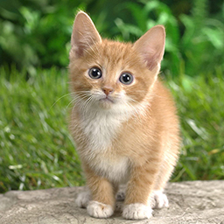

In [26]:

display(img)

Compile the model with relay



In [27]:
target = "llvm"

input_name = "1"
shape_dict = {input_name: x.shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    intrp = relay.build_module.create_executor("graph", mod, tvm.cpu(0), target)

The tutorial includes warnings, jesus christ

Now Exceute the model on TVM

In [28]:
dtype = "float32"
tvm_output = intrp.evaluate()(tvm.nd.array(x.astype(dtype)), **params).asnumpy()

Display the results

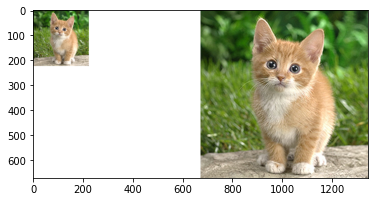

In [30]:
from matplotlib import pyplot as plt

out_y = Image.fromarray(np.uint8((tvm_output[0, 0]).clip(0, 255)), mode="L")
out_cb = img_cb.resize(out_y.size, Image.BICUBIC)
out_cr = img_cr.resize(out_y.size, Image.BICUBIC)
result = Image.merge("YCbCr", [out_y, out_cb, out_cr]).convert("RGB")
canvas = np.full((672, 672 * 2, 3), 255)
canvas[0:224, 0:224, :] = np.asarray(img)
canvas[:, 672:, :] = np.asarray(result)
plt.imshow(canvas.astype(np.uint8))
plt.show()